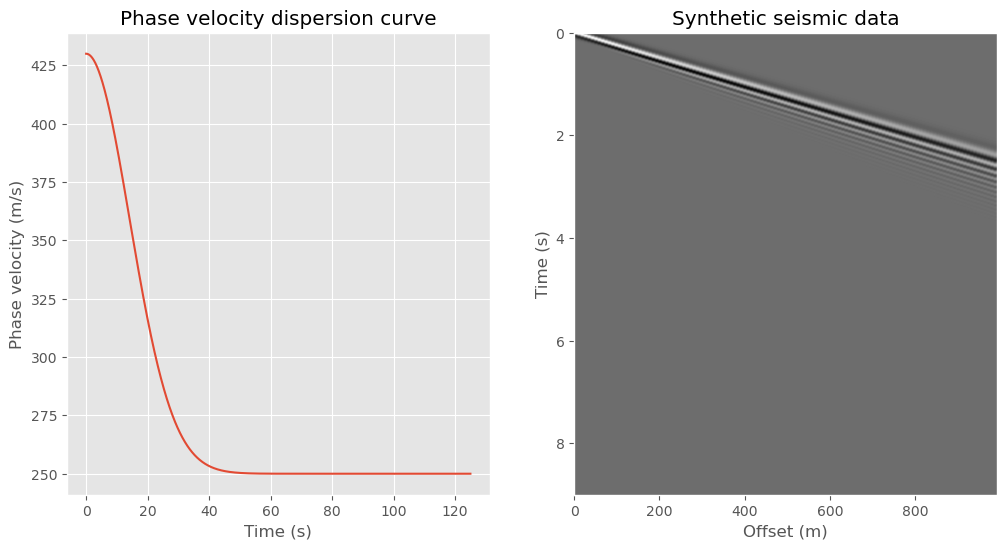

In [1]:

# from SWC_cn import ricker, Pv2Gv
import numpy as np


import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import (fft, ifft)
from scipy import interpolate


def ricker(f, dt):
    """
    生成Ricker波形，通常用于地震勘探中的震源信号。

    参数:
    f : 震源主频率
    dt : 采样间隔

    返回值:
    tw : 时间窗口
    w : Ricker波形
    """
    # 计算波形长度
    nw = int(2./dt)
    nw = 2 * int(nw/2)
    nc = int(nw/2)

    # 计算Ricker波形
    k = np.arange(1, nw, 1)
    alpha = (nc - k + 1) * f * dt * np.pi
    beta = alpha ** 2
    w = (1 - 2 * beta) * np.exp(-beta)

    # 计算时间窗口
    tw = - (nc + 1 - np.arange(1, nw, 1)) * dt

    return tw, w


def Pv2Gv(Pv, f):
    """
    将相位速度转换为群速度。

    参数:
    Pv : 相位速度
    f : 频率

    返回值:
    Gv : 群速度
    f : 频率（去除了最后一个元素，与群速度对应）
    """
    f = f.reshape(-1,)
    Pv = Pv.reshape(-1,)

    m = len(f)
    sp = 1 / Pv
    dsp = np.diff(sp) / np.diff(f)
    sga = dsp * f[:-1] + sp[:-1]
    Gv = 1 / sga

    return Gv, f[:-1]


def synthetic(f=5.5, dt=0.004, v0=250, dv=180, sigma=20, decay=50000, x=np.arange(0, 1000, 8)):
    """
    基于色散曲线生成合成地表波数据。

    参数:
    f : float
        震源主频率(Hz)。
    dt : float
        采样间隔(s)。
    v0 : float
        色散曲线的起始相位速度(m/s)。
    dv : float
        相位速度随频率变化的增量。
    sigma : float
        控制色散曲线形状的参数。
    decay : float
        表示衰减系数。
    x : ndarray
        探测点位置数组(m)。

    返回值:
    t : ndarray
        时间数组(s)。
    fn : ndarray
        合成地震数据，各列对应于位置数组x的不同位置。
    f : ndarray
        用于生成合成数据的频率数组(Hz)。
    sf : ndarray
        震源信号的频谱。
    v : ndarray
        相位速度数组(m/s)。
    """
    # 生成Ricker波形及其频谱
    tw, sr = ricker(f, dt)
    fsr = fft(sr, n=2500, axis=0)
    fnq = 1 / dt
    nsr = len(fsr)

    # 计算频率数组和频谱的一半（正频率部分）
    f = np.linspace(0, fnq/2, nsr//2)
    sf = fsr[:nsr//2]

    # 根据频率计算色散曲线上的相位速度
    v = v0 + dv * np.exp(-f**2 / sigma**2)
    k = f / v

    # 计算群速度
    gv, f2 = Pv2Gv(v, f)

    # 计算衰减系数
    beta = f / decay
    
    # 初始化合成地震数据的频率域表示
    h2 = np.zeros([nsr//2, len(x)], dtype=np.complex128)

    # 基于色散和衰减效应计算合成地震数据的频率域表示
    for i in range(nsr//2):
        h2[i, :] = sf[i] * np.exp(-2 * 1j * np.pi * k[i] * x) * np.exp(-beta[i] * x)
    
    # 通过逆傅里叶变换将数据转换回时间域并取实部
    fn = np.real(ifft(h2, n=nsr, axis=0))
    fn = fn[len(tw)//2-1:]

    # 计算时间数组
    t = np.arange(fn.shape[0]) * dt

    plt.figure(figsize = (10, 3))
    plt.subplot(141)
    plt.plot(f, v)
    plt.xlabel('Frequency')
    plt.ylabel('Phase velocity')
    plt.subplot(142)
    plt.plot(f2, gv)
    plt.xlabel('Frequency')
    plt.ylabel('Group velocity')
    plt.subplot(143)
    plt.plot(f, beta)
    plt.xlabel('Frequency')
    plt.ylabel('Attenuation')
    plt.subplot(144)
    plt.plot(f, k)
    plt.xlabel('Frequency')
    plt.ylabel('Wavenumber')

    return t, fn, f, sf, v


def Slow2Vel(M, q):
    """
    将慢度转换为速度。

    参数:
    M : 慢度矩阵
    q : 慢度向量

    返回值:
    ynew : 转换后的速度矩阵
    """
    ynew = np.zeros_like(M)
    xnew = np.linspace(1/q[-1], 1/q[0], len(q))

    for i in range(M.shape[1]):
        x = 1 / q
        y = M[:, i]
        f = interpolate.interp1d(x, y, fill_value="extrapolate")
        ynew[:, i] = f(xnew)
        
    return ynew



def syntheticSeismic(x=np.arange(0, 1000, 8), f=5.5, dt=0.004, v0=250, dv=180, sigma=20, decay=50000):
    """
    Generate synthetic seismic data using the Ricker wavelet and the phase velocity dispersion curve.
    Parameters
    ----------
    f : float
        Peak frequency of the Ricker wavelet in Hz.
    dt : float
        Sampling interval in s.
    v0 : float
        Initial phase velocity in m/s.
    dv : float
        Change in phase velocity in m/s.
    sigma : float
        Width of the Gaussian function in Hz.
    decay : float
        Decay factor in 1/m.

    Returns
    -------
    t : ndarray
        Time array in s.
    fn : ndarray
        Synthetic seismic data.
    f : ndarray
        Frequency array in Hz.
    sf : ndarray
        Spectrum of the Ricker wavelet.
    v : ndarray
        Phase velocity array in m/s.
    """
    
    
    # 生成Ricker波形及其频谱
    tw, sr = ricker(f, dt)
    fsr = np.fft.fft(sr, n=2500, axis=0)
    fnq = 1 / dt
    nsr = len(fsr)

    # 计算频率数组和频谱的一半（正频率部分）
    f = np.linspace(0, fnq/2, nsr//2)
    sf = fsr[:nsr//2]

    # 根据频率计算频散曲线上的相位速度
    v = v0 + dv * np.exp(-f**2 / sigma**2)
    k = f / v

    # 计算衰减系数
    beta = f / decay

    # 初始化合成地震数据的频率域表示
    h2 = np.zeros([nsr//2, len(x)], dtype=np.complex128)

    # 基于色散和衰减效应计算合成地震数据的频率域表示
    for i in range(nsr//2):
        h2[i, :] = sf[i] * np.exp(-2 * 1j * np.pi * k[i] * x) * np.exp(-beta[i] * x)

    # 通过逆傅里叶变换将数据转换回时间域并取实部
    fn = np.real(np.fft.ifft(h2, n=nsr, axis=0))
    fn = fn[len(tw)//2-1:]

    # 计算时间数组
    t = np.arange(fn.shape[0]) * dt

    return t, fn, f, sf, v

if __name__ == '__main__':
    import matplotlib.pyplot as plt
    import numpy as np
    dt = 0.004
    x = np.arange(0, 1000, 8)
    t, fn, f, sf, v = syntheticSeismic(x=x, dt=dt)

    with plt.style.context('ggplot'):
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].plot(f, v)
        axes[0].set_xlabel('Time (s)')
        axes[0].set_ylabel('Phase velocity (m/s)')
        axes[0].set_title('Phase velocity dispersion curve')

        axes[1].imshow(fn, aspect='auto', extent=[x[0], x[-1], t[-1], 0], cmap='gray')
        axes[1].set_xlabel('Offset (m)')
        axes[1].set_ylabel('Time (s)')
        axes[1].set_title('Synthetic seismic data')
        axes[1].grid(False)


In [2]:
dt    = 0.004
x     = np.arange(0, 1000, 8)
f     = 5.5
v0    = 250
dv    = 180
sigma = 20
decay = 50000


# 生成Ricker波形及其频谱
tw, sr = ricker(f, dt)
fsr = np.fft.fft(sr, n=2500, axis=0)
fnq = 1 / dt
nsr = len(fsr)

# 计算频率数组和频谱的一半（正频率部分）
f  = np.linspace(0, fnq/2, nsr//2)
sf = fsr[:nsr//2]

tw.shape, sr.shape, fsr.shape, f.shape, sf.shape

((499,), (499,), (2500,), (1250,), (1250,))

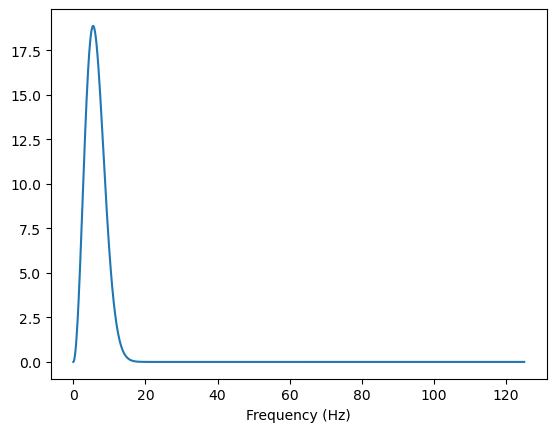

In [3]:
plt.plot(f, np.abs(sf))
plt.xlabel('Frequency (Hz)')
plt.show()

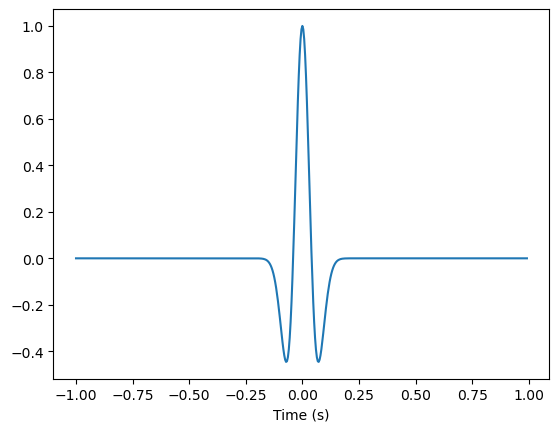

In [4]:
plt.plot(tw, sr)
plt.xlabel('Time (s)')
plt.show()

In [5]:
# 根据频率计算频散曲线上的相位速度
v = v0 + dv * np.exp(-f**2 / sigma**2)
k = f / v

v.shape, k.shape

((1250,), (1250,))

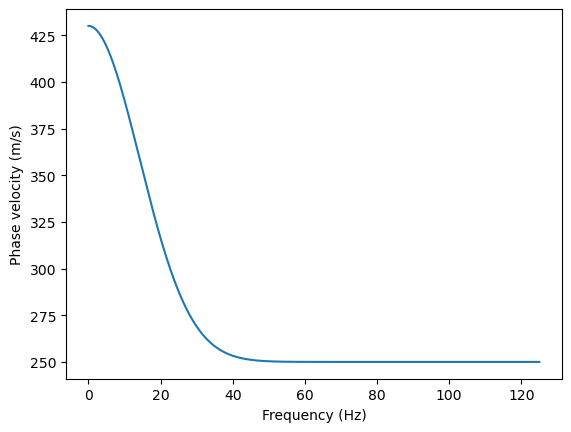

In [6]:
plt.plot(f, v)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase velocity (m/s)')
plt.show()

In [7]:
# 计算衰减系数
beta = f / decay

# 初始化合成地震数据的频率域表示
h2 = np.zeros([nsr//2, len(x)], dtype=np.complex128)

# 基于色散和衰减效应计算合成地震数据的频率域表示
for i in range(nsr//2):
    h2[i, :] = sf[i] * np.exp(-2 * 1j * np.pi * k[i] * x) * np.exp(-beta[i] * x)

h2.shape

(1250, 125)

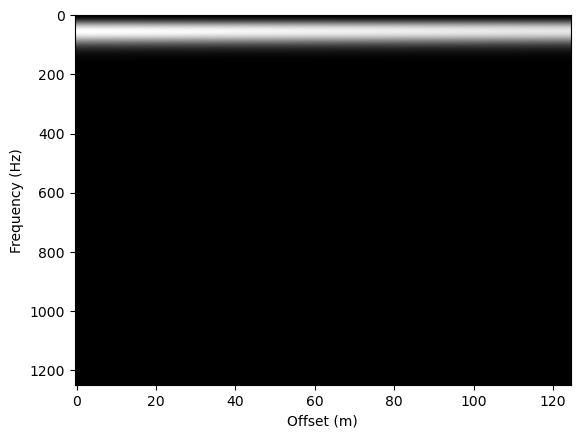

In [8]:
plt.imshow(np.abs(h2), aspect='auto', cmap='gray')
plt.xlabel('Offset (m)')
plt.ylabel('Frequency (Hz)')
plt.show()

In [9]:
# 通过逆傅里叶变换将数据转换回时间域并取实部
fn = np.real(np.fft.ifft(h2, n=nsr, axis=0))
fn = fn[len(tw)//2-1:]

fn.shape

(2252, 125)

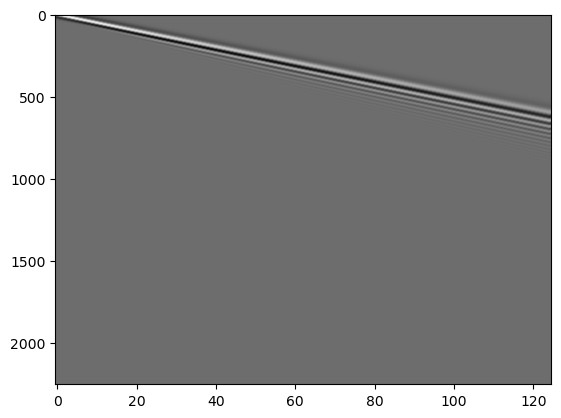

In [10]:
plt.imshow(fn, aspect='auto', cmap='gray')
plt.show()